In [1]:
from tensorflow.keras.layers import Input,Dense,LSTM,Flatten
from tensorflow.keras.models import Model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import MetaTrader5 as mt5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [2]:
markets = ["AUDUSD","EURUSD","GBPUSD","USDCAD","USDCHF","XAUUSD","NZDUSD"]
if not mt5.initialize():
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')

else: 
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())

{'login': 75525372, 'trade_mode': 0, 'leverage': 100, 'limit_orders': 200, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 66.29, 'credit': 0.0, 'profit': 0.0, 'equity': 66.29, 'margin': 0.0, 'margin_free': 66.29, 'margin_level': 0.0, 'margin_so_call': 50.0, 'margin_so_so': 30.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'mike bright', 'server': 'MetaQuotes-Demo', 'currency': 'USD', 'company': 'MetaQuotes Software Corp.'}


{'community_account': True, 'community_connection': True, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 4076, 'maxbars': 100000, 'codepage': 0, 'ping_last': 144013, 'community_balance': 0.0, 'retransmission': 0.38251266485422586, 'company': 'MetaQuotes So

In [15]:
n = 5
rates = mt5.copy_rates_from_pos(markets[n], mt5.TIMEFRAME_M5, 0, 99999)
#print(rates)
print(rates.shape)
x = []
y = []


for i in range(len(rates)):
    x.append([rates[i][1],rates[i][5]])
    y.append(rates[i][4])


x = np.array(x)
y = np.array(y)



(99999,)


In [16]:
print(x)
print(y)

print(x.shape)
print(y.shape)

[[1831.45  826.  ]
 [1831.82  798.  ]
 [1830.67  553.  ]
 ...
 [2039.06  647.  ]
 [2039.35  492.  ]
 [2038.94  500.  ]]
[1831.82 1830.74 1830.92 ... 2039.32 2038.97 2039.46]
(99999, 2)
(99999,)


In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, random_state=0)


x_test = x_test[:-100]
y_test = y_test[:-100]



print(x_train.shape)
print(x_test.shape)



(96999, 2)
(2900, 2)


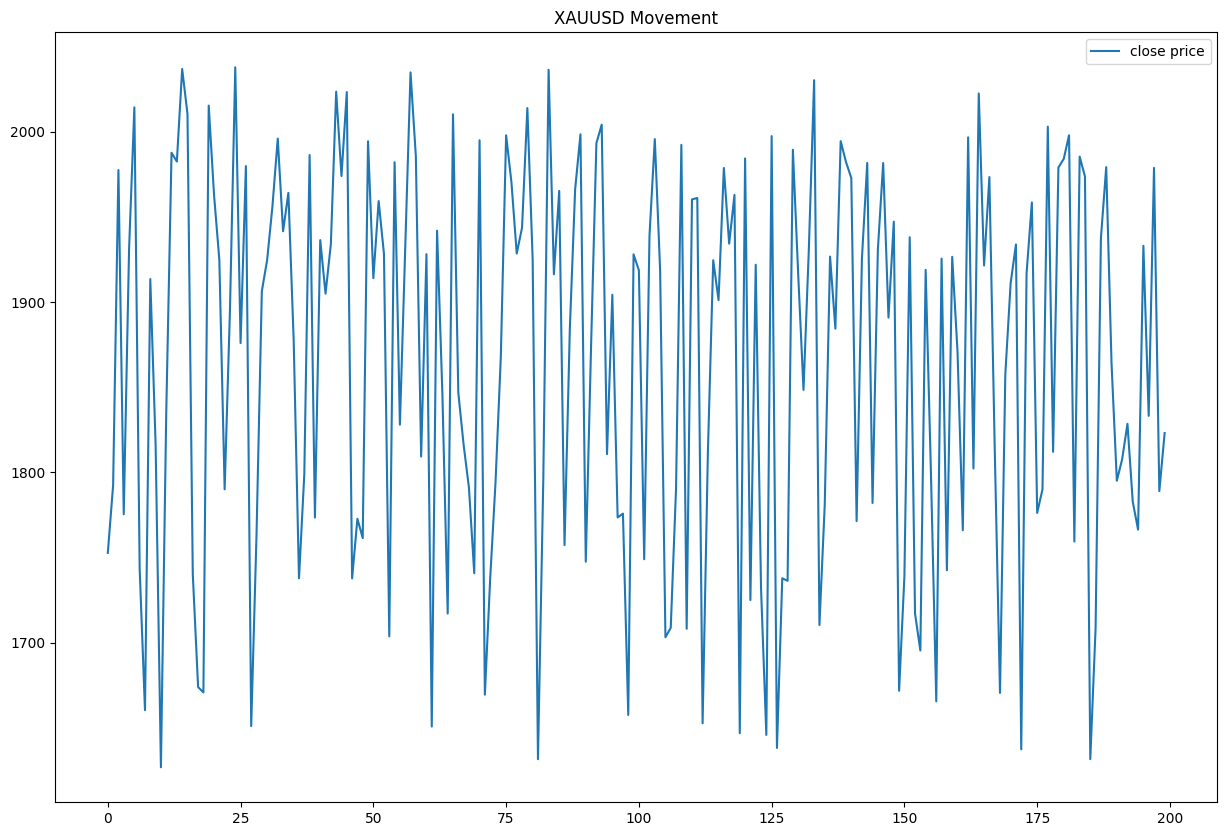

In [26]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+' Movement')
plt.plot(y_test[-200:], label="close price")
#plt.plot(x_test[-200:], label="open price")
plt.legend()
plt.show()

In [27]:
sc_x = StandardScaler()
sc_y = StandardScaler()

x_train = sc_x.fit_transform(x_train)
y_train = sc_y.fit_transform(y_train.reshape((len(y_train),1)))
y_train = y_train.reshape(-1)

x_test = sc_x.transform(x_test)
y_test = sc_y.transform(y_test.reshape((len(y_test),1)))
y_test = y_test.reshape(-1)
print(x_train)
print(y_train)




[[-0.30159644 -0.74888798]
 [ 0.91996267  0.28701476]
 [ 0.51226956  0.35360851]
 ...
 [ 0.10895831  0.50652749]
 [ 0.02391419 -0.53430812]
 [ 0.80603396 -0.16187642]]
[-0.30268718  0.91152346  0.51090012 ...  0.09578996  0.02138848
  0.81226188]


In [28]:
timesteps = 1
samples = x_train.shape[0]
features = x_train.shape[1]

x_train = x_train[:samples*timesteps].reshape((samples, timesteps, features))

samples = x_test.shape[0]
features = x_test.shape[1]

x_test = x_test[:samples*timesteps].reshape((samples, timesteps, features))

print(x_train.shape)
print(x_test.shape)

(96999, 1, 2)
(2900, 1, 2)


In [29]:
print(x_train[0].shape)
print(x_test.shape)

(1, 2)
(2900, 1, 2)


In [30]:
i = Input(shape = x_train[0].shape)

X = LSTM(512, return_sequences=True)(i)
X = LSTM(256, return_sequences=True)(X)
X = LSTM(128, return_sequences=True)(X)
X = LSTM(64)(X)
X = Dense(64, activation="relu")(X)
X = Dense(1)(X)

model = Model(i, X)

model.compile(
    loss='mse',
    optimizer='adam'
)


r = model.fit(
    x_train,y_train,
    batch_size = 2048,
    epochs = 1000,
    validation_data = (x_test, y_test)
)

Epoch 1/1000
48/48 [==============================] - 13s 61ms/step - loss: 0.4327 - val_loss: 0.0192
Epoch 2/1000
48/48 [==============================] - 1s 21ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 3/1000
48/48 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/1000
48/48 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 6.9637e-04
Epoch 5/1000
48/48 [==============================] - 1s 20ms/step - loss: 4.3269e-04 - val_loss: 2.9384e-04
Epoch 6/1000
48/48 [==============================] - 1s 20ms/step - loss: 2.2646e-04 - val_loss: 1.9910e-04
Epoch 7/1000
48/48 [==============================] - 1s 20ms/step - loss: 1.7521e-04 - val_loss: 1.6299e-04
Epoch 8/1000
48/48 [==============================] - 1s 20ms/step - loss: 1.5254e-04 - val_loss: 1.4337e-04
Epoch 9/1000
48/48 [==============================] - 1s 22ms/step - loss: 1.4108e-04 - val_loss: 1.3246e-04
Epoch 10/1000
48/48 [=========================

In [31]:
model.evaluate(x_test,y_test)

91/91 [==============================] - 1s 8ms/step - loss: 6.7434e-05


6.743444100720808e-05

In [32]:
def r_squared(y_true, y_pred):
  """Calculates the R-squared score.

  Args:
    y_true: The ground truth values.
    y_pred: The predicted values.

  Returns:
    The R-squared score.
  """

  mean_y_true = np.mean(y_true)
  ss_tot = np.sum((y_true - mean_y_true)**2)
  ss_res = np.sum((y_true - y_pred)**2)
  r_squared = 1 - ss_res / ss_tot
  return r_squared

y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)
score = r_squared(y_test[-100:], y_pred[-100:])

print(score)

91/91 [==============================] - 3s 8ms/step
0.9999109863895609


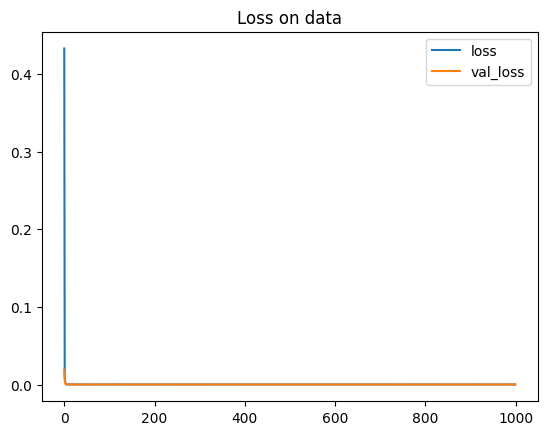

In [33]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [34]:
y_test = sc_y.inverse_transform(y_test.reshape((len(y_test),1)))
y_pred = model.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred.reshape((len(y_pred),1)))

91/91 [==============================] - 1s 7ms/step


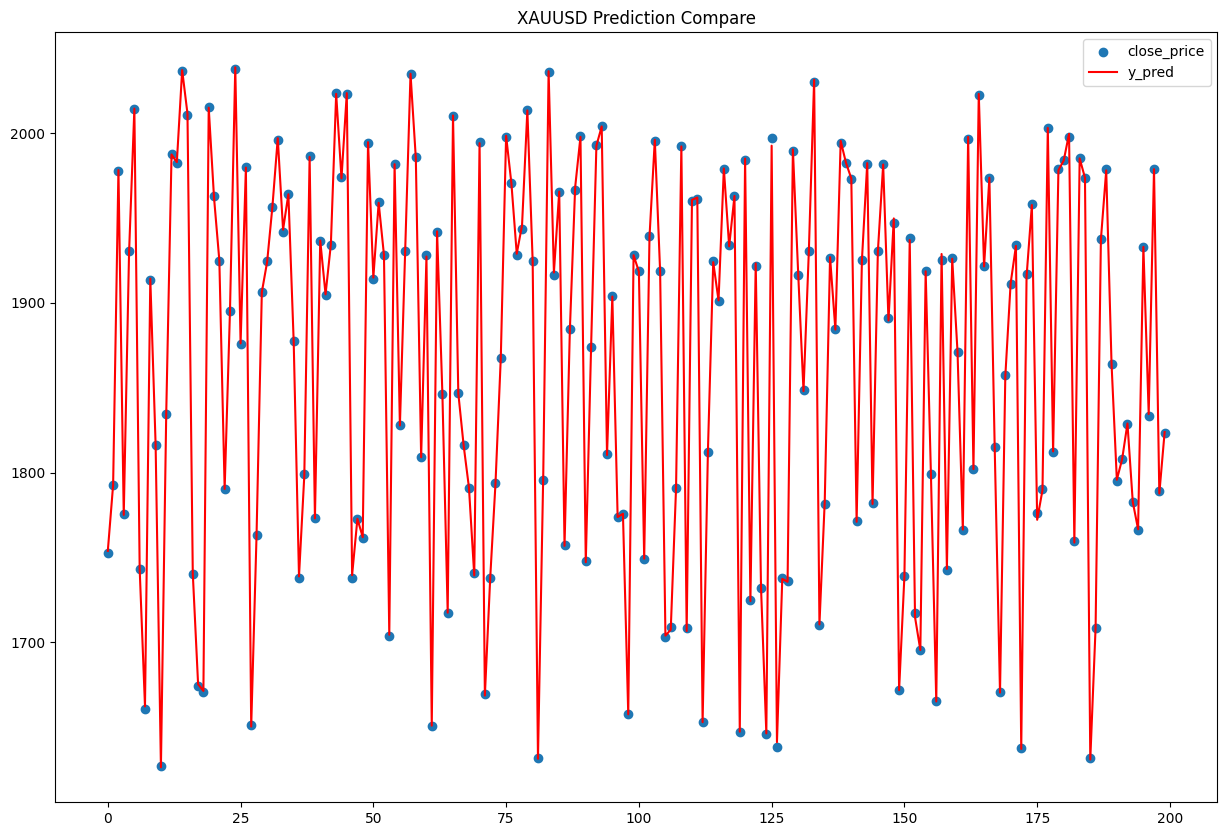

In [35]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+" Prediction Compare")
x_point = []

for i in range(len(y_test[-200:])):
  t = [i]
  x_point.append(t)
plt.scatter(x_point, y_test[-200:], label="close_price")
#plt.plot(y_test, label="y_test")

plt.plot(y_pred[-200:], label="y_pred", color="red")

plt.legend()

plt.show()

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1054720   
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65    

In [37]:
model.save(markets[n]+".keras")

In [38]:
import joblib

joblib.dump(sc_x,markets[n]+ ' sc_x.joblib')
joblib.dump(sc_y,markets[n]+ ' sc_y.joblib')

['XAUUSD sc_y.joblib']

In [ ]:

from tensorflow.keras.models import load_model

model_list = [
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/AUDUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURGBP 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/GBPUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCAD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCHF 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/XAUUSD 1695362400.0.keras',
    "/content/drive/MyDrive/forex data/dbot_model.keras"
  ]

for target_list in model_list:
  # Load the Keras model
  model = load_model(target_list)
  model.save(target_list+".h5")
  # Convert the Keras model to ONNX
  #onnx_model = ox.convert_keras(model)

  # Save the ONNX model
  #onnx.save_model(onnx_model, target_list+'.onnx')